In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from grid_search import *
from costs import *
from helpers import *
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [2]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    
    w = np.linalg.solve(tx.T @ tx, tx.T @ y)
    mse = compute_loss(y, tx, w)
    return mse, w

In [3]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for i in range(len(w1)):
        for j in range(len(w0)):
            losses[i,j] = costs.compute_loss(y,tx,[w0[j],w1[i]])
            
    return get_best_parameters(w0, w1, losses)

### 1.2 Debug

In [4]:
def prediction(w0, w1, mean_x, std_x):
    """Get the regression line from the model."""
    x = np.arange(1.2, 2, 0.01)
    x_normalized = (x - mean_x) / std_x
    return x, w0 + w1 * x_normalized

def base_visualization(w, w0_list, w1_list,mean_x, std_x, height, weight):
    """Base Visualization for both models."""
    w0, w1 = np.meshgrid(w0_list, w1_list)

    fig = plt.figure()

    # plot f(x)
    x, f = prediction(w[0], w[1], mean_x, std_x)
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(height, weight, marker=".", color='b', s=5)
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.grid()
    ax2.plot(x, f, 'r')

    return fig

In [5]:
num_intervals = 250

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [6]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    grid_w0, grid_w1 = generate_w(num_intervals)

    mse_g,w0,w1 = grid_search(y,tx,grid_w0,grid_w1)
    w_g = [w0,w1]             
    mse_s,w_s = least_squares(y,tx)
    
    fig = base_visualization(w_s, grid_w0, grid_w1, mean_x, std_x, height, weight)
    fig = base_visualization(w_g, grid_w0, grid_w1, mean_x, std_x, height, weight)    

    print('Grid',mse_g,w_g)
    print('Least Square',mse_s,w_s)

Test it here

Grid 15.4764773715 [63.855421686747007, 23.493975903614484]
Least Square 15.3858878688 [ 73.293922    13.47971243]


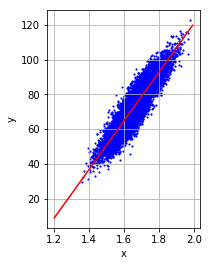

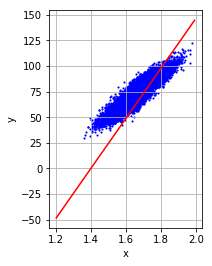

In [7]:
test_your_least_squares()

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [8]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [9]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    phi_x = np.ones((len(x), 1))
        
    for j in range(1, degree + 1):
        x_power_j = np.power(x, j)
        phi_x = np.c_[phi_x, x_power_j]

    return phi_x

In [10]:
build_poly([2,3,5], 6)

array([[  1.00000000e+00,   2.00000000e+00,   4.00000000e+00,
          8.00000000e+00,   1.60000000e+01,   3.20000000e+01,
          6.40000000e+01],
       [  1.00000000e+00,   3.00000000e+00,   9.00000000e+00,
          2.70000000e+01,   8.10000000e+01,   2.43000000e+02,
          7.29000000e+02],
       [  1.00000000e+00,   5.00000000e+00,   2.50000000e+01,
          1.25000000e+02,   6.25000000e+02,   3.12500000e+03,
          1.56250000e+04]])

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [11]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        x1 = build_poly(x, degree)
        mse, weights = least_squares(y, x1)
        rmse = np.sqrt(2*mse)
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.258582776677375
Processing 3th experiment, degree=7, rmse=0.24965870360907585
Processing 4th experiment, degree=12, rmse=0.24125747399269168


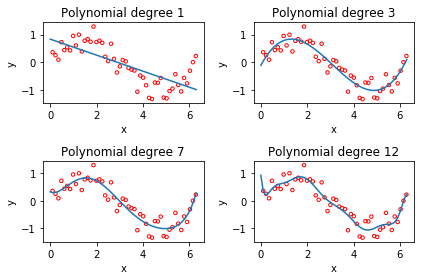

In [12]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [13]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)

    # split the data based on the given ratio

    idx = [i for i in range(len(x))]
    np.random.shuffle(idx)
    split = int(len(x) * ratio)
    
    x_shuffle = x[idx]
    y_shuffle = y[idx]
    
    x_train = x_shuffle[:split]
    x_test = x_shuffle[split:]
    y_train = y_shuffle[:split]
    y_test = y_shuffle[split:]
    
    return x_train, x_test, y_train, y_test

Then, test your `split_data` function below.

In [14]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    train_poly = build_poly(x_train, degree)
    test_poly = build_poly(x_test, degree)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calcualte weight through least square.: TODO
    # ***************************************************
    mse_train, weights_train = least_squares(y_train, train_poly)
    mse_test = compute_loss(y_test, test_poly, weights_train)
    # ***************************************************
    # INSERT YOUR CODE HER
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: TODO
    # ***************************************************
    rmse_tr = np.sqrt(2 * mse_train)
    rmse_te = np.sqrt(2 * mse_test)
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [15]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.278, Testing RMSE=0.349
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.266
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.170
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=2.999


# 3 Ridge Regression
Please fill in the function below.

In [16]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************
    lambda_prime = 2*len(x)*lambda_
    first_term = tx.T@tx
    w_ridge = np.linalg.solve(first_term + lambda_prime *np.identity(len(first_term)), tx.T @ y)
    mse = compute_loss(y, tx, w_ridge)
    return mse, w_ridge

In [29]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    train_poly = build_poly(x_train, degree)
    test_poly = build_poly(x_test, degree)
    
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ridge regression with a given lambda
        # ***************************************************
        
        mse_train, weights_train = ridge_regression(y_train, train_poly, lambda_)
        mse_test = compute_loss(y_test, test_poly, weights_train)
        
        rmse_tr.append(np.sqrt(2 * mse_train))
        rmse_te.append(np.sqrt(2 * mse_test))
    
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


(25,)
(25, 8)
(8,)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=1.302, Testing RMSE=15.816
(8,)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=1.303, Testing RMSE=13.225
(8,)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=1.308, Testing RMSE=11.149
(8,)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=1.321, Testing RMSE=8.867
(8,)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=1.345, Testing RMSE=6.472
(8,)
proportion=0.5, degree=7, lambda=0.001, Training RMSE=1.374, Testing RMSE=4.527
(8,)
proportion=0.5, degree=7, lambda=0.001, Training RMSE=1.397, Testing RMSE=3.261
(8,)
proportion=0.5, degree=7, lambda=0.003, Training RMSE=1.415, Testing RMSE=2.423
(8,)
proportion=0.5, degree=7, lambda=0.007, Training RMSE=1.433, Testing RMSE=1.772
(8,)
proportion=0.5, degree=7, lambda=0.016, Training RMSE=1.456, Testing RMSE=1.287
(8,)
proportion=0.5, degree=7, lambda=0.037, Training RMSE=1.483, Testing RMSE=0.987
(8,)
proportion=0.5, degree=7, lambda=0.085, Tra

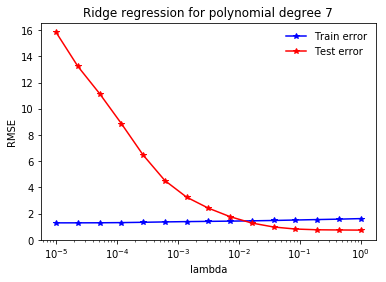

In [30]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)

In [44]:
def ridge_regression2(y, tx, lambda_):
    """implement ridge regression."""
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    return np.linalg.solve(a, b)

In [39]:
def split_data2(x, y, ratio, myseed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(myseed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

In [40]:
def compute_mse2(y, tx, w):
    """compute the loss by mse."""
    e = y - tx.dot(w)
    mse = e.dot(e) / (2 * len(e))
    return mse

(8,)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
(8,)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
(8,)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
(8,)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
(8,)
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
(8,)
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
(8,)
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
(8,)
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
(8,)
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
(8,)
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
(8,)
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
(8,)
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264,

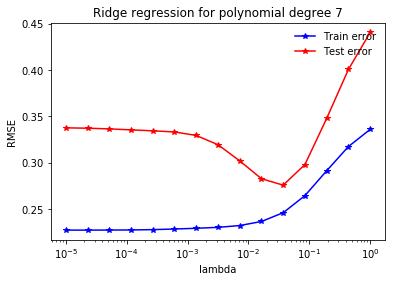

In [47]:
def ridge_regression_demo2(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # split data
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)
    # form tx
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)

    # ridge regression with different lambda
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ridge regression
        weight = ridge_regression2(y_tr, tx_tr, lambda_)
        print(np.shape(weight))
        rmse_tr.append(np.sqrt(2 * compute_mse(y_tr, tx_tr, weight)))
        rmse_te.append(np.sqrt(2 * compute_mse(y_te, tx_te, weight)))

        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo2(x, y, degree, split_ratio, seed)

In [ ]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo2(x, y, degree, split_ratio, seed)